### Import libraries

In [15]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

# this is to supress the scientific notation when we check on the data frames
pd.options.display.float_format = '{:20,.2f}'.format

### Get the previous and the current 13F form

In [2]:
user_agent = {'User-agent': 'Mozilla/5.0'}

cusip = '1067983'

Q423_url = f'https://www.sec.gov/Archives/edgar/data/{cusip}/000095012324002518/30197.xml'
Q423_responce = requests.get(Q423_url, headers=user_agent)
print(Q423_responce.status_code)

Q324_url = f'https://www.sec.gov/Archives/edgar/data/{cusip}/000095012323011029/28498.xml'
Q324_responce = requests.get(Q324_url, headers=user_agent)
print(Q324_responce.status_code)

Q223_url = f'https://www.sec.gov/Archives/edgar/data/{cusip}/000095012323008074/25376.xml'
Q223_responce = requests.get(Q223_url, headers=user_agent)
print(Q223_responce.status_code)

Q123_url = f'https://www.sec.gov/Archives/edgar/data/{cusip}/000095012323002585/20651.xml'
Q123_responce = requests.get(Q123_url, headers=user_agent)
print(Q123_responce.status_code)




200
200
200
200


### Create a function to parse the 13F form and return a dataframe


In [3]:
def parse13f(xml):
    tree = ET.ElementTree(ET.fromstring(xml))
    root = tree.getroot()
    
    # Remove the namespace from all elements
    for elem in root.iter():
        # Check if element has a namespace
        if '}' in elem.tag:
            # Remove namespace prefix
            elem.tag = elem.tag.split('}')[1]
        else:
            # No namespace prefix found, keep the tag unchanged
            pass
    
    list_of_holdings = []
    
    # find all infoTable
    for infoTable in root.iter('infoTable'):
        holding = {}
        for c in infoTable.iter():
                if c.tag == 'nameOfIssuer':
                    holding['nameOfIssuer'] = c.text
                if c.tag == 'cusip':
                    holding['cusip'] = c.text
                if c.tag == 'value':
                    holding['value'] = c.text
                if c.tag == 'sshPrnamt':
                    holding['sharesAmount'] = c.text
        list_of_holdings.append(holding)
        
    df = pd.DataFrame(list_of_holdings)
    df['value'] = df['value'].astype(float)/1000
    df['sharesAmount'] = df['sharesAmount'].astype(float)/1000
    
    group_by = ['nameOfIssuer','cusip']
    df = df.groupby(group_by, as_index=False).sum()
    
    return df
    
    

### Parse the 13F form for the current and the previous report

In [4]:
dfQ423 = parse13f(Q423_responce.text)
dfQ324 = parse13f(Q324_responce.text)
dfQ223 = parse13f(Q223_responce.text)
dfQ123 = parse13f(Q123_responce.text)   


### analyse the data set

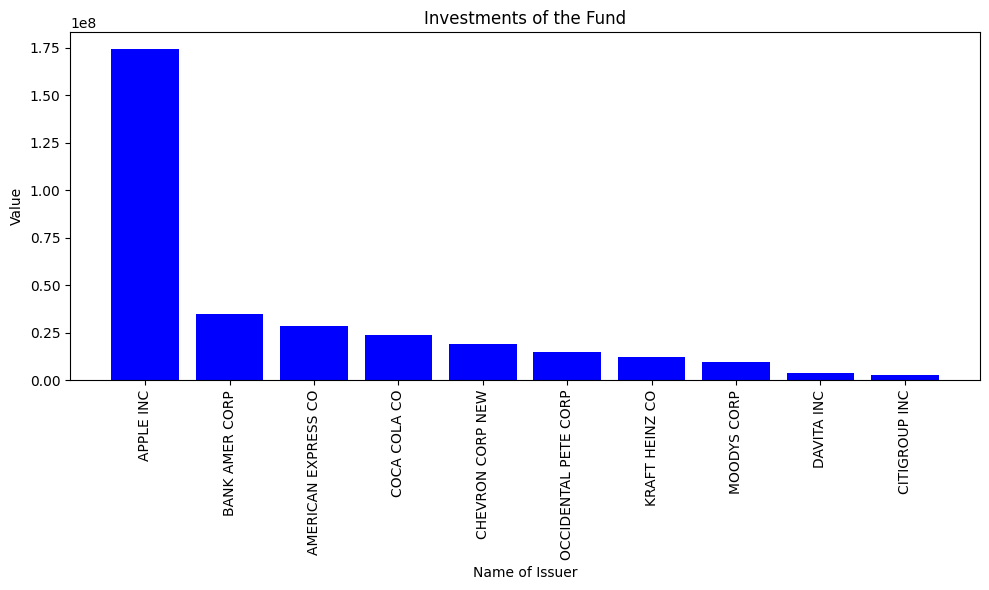

In [6]:
df = dfQ423.copy().sort_values(by=['value'], ascending=False)
df = df.head(10)
plt.figure(figsize=(10, 6))
plt.bar(df["nameOfIssuer"], df["value"], color='blue')
plt.xlabel('Name of Issuer')
plt.ylabel('Value')
plt.title('Investments of the Fund')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

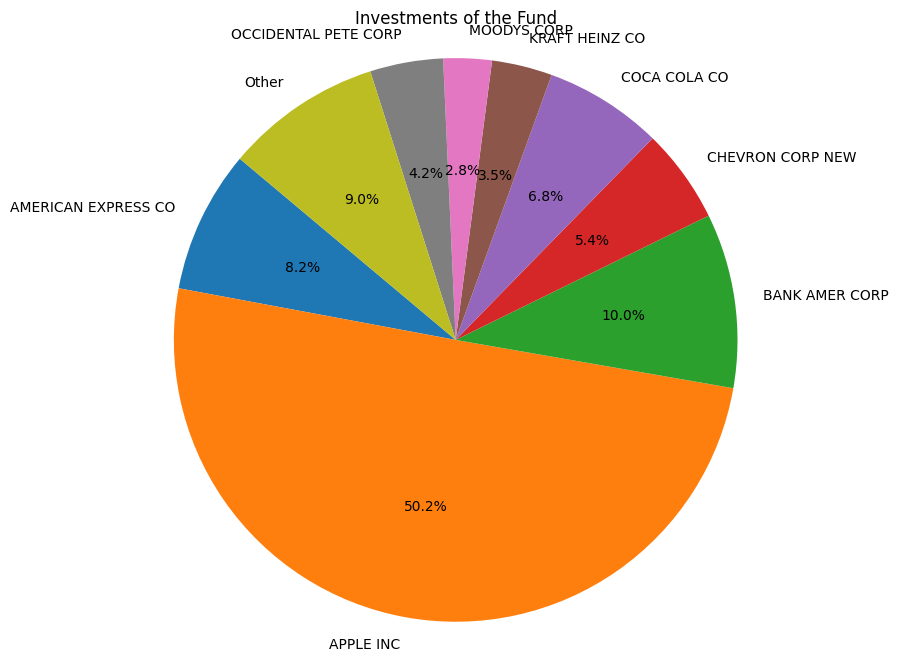

In [9]:
df = dfQ423.copy().sort_values(by=['value'], ascending=False)

# Calculate threshold for smaller investments to be grouped
df_sorted = df.sort_values(by='value', ascending=False)
threshold = df_sorted.iloc[7]['value']

# Aggregate smaller investments into "Other"
df.loc[df["value"] < threshold, "nameOfIssuer"] = "Other"
df = df.groupby("nameOfIssuer").sum().reset_index()

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(df["value"], labels=df["nameOfIssuer"], autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Investments of the Fund')
plt.show()

In [32]:

list_of_dfs = [dfQ423, dfQ324, dfQ223, dfQ123]
list_of_suffixes = ['_Q423', '_Q324', '_Q223', '_Q123']

for i in range( len(list_of_dfs)):
    sum_of_portfolio = list_of_dfs[i]['value'].sum()
    list_of_dfs[i] = list_of_dfs[i][['nameOfIssuer', 'cusip', 'value', 'sharesAmount']]
    list_of_dfs[i]['inv_perc'] = (list_of_dfs[i]['value'] / sum_of_portfolio)*100

final_df = dfQ423.copy()

for i in range( len(list_of_dfs)):
    final_df = pd.merge(final_df, list_of_dfs[i], on=['nameOfIssuer', 'cusip'], how='outer', suffixes=(list_of_suffixes[i-1], list_of_suffixes[i]))
    
final_df

,nameOfIssuer,cusip,value_Q123,sharesAmount_Q123,value_Q423,sharesAmount_Q423,inv_perc_Q423,value_Q324,sharesAmount_Q324,inv_perc_Q324,value_Q223,sharesAmount_Q223,inv_perc_Q223,value,sharesAmount,inv_perc_Q123
0,ACTIVISION BLIZZARD INC,00507V109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,235,679.60","14,658.12",0.35,"4,035,492.09","52,717.07",1.35
1,ALLY FINL INC,02005N100,"1,012,680.00","29,000.00","1,012,680.00","29,000.00",0.29,"773,720.00","29,000.00",0.25,"783,290.00","29,000.00",0.22,"728,610.00","29,800.00",0.24
2,AMAZON COM INC,023135106,"1,519,400.00","10,000.00","1,519,400.00","10,000.00",0.44,"1,271,200.00","10,000.00",0.41,"1,375,428.36","10,551.00",0.40,"895,944.00","10,666.00",0.30
3,AMERICAN EXPRESS CO,025816109,"28,402,748.54","151,610.70","28,402,748.54","151,610.70",8.18,"22,618,800.33","151,610.70",7.22,"26,410,583.94","151,610.70",7.59,"22,400,480.93","151,610.70",7.49
4,AON PLC,G0403H108,"1,193,182.00","4,100.00","1,193,182.00","4,100.00",0.34,"1,329,302.00","4,100.00",0.42,"1,496,442.00","4,335.00",0.43,"1,319,415.44","4,396.00",0.44
5,APPLE INC,037833100,"174,347,466.80","905,560.00","174,347,466.80","905,560.00",50.19,"156,753,093.00","915,560.38",50.04,"177,591,247.30","915,560.38",51.00,"116,305,043.22","895,136.17",38.90
6,ATLANTA BRAVES HLDGS INC,047726302,"8,851.87",223.65,"8,851.87",223.65,0.00,"7,990.84",223.65,0.00,NaN,NaN,NaN,NaN,NaN,NaN
7,BANK AMER CORP,060505104,"34,776,127.04","1,032,852.01","34,776,127.04","1,032,852.01",10.01,"28,279,487.92","1,032,852.01",9.03,"29,632,524.05","1,032,852.01",8.51,"33,454,532.07","1,010,100.61",11.19
8,BANK OF NEW YORK MELLON CORP,064058100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1,141,180.35","25,069.87",0.38
9,CAPITAL ONE FINL CORP,14040H105,"1,635,201.45","12,471.03","1,635,201.45","12,471.03",0.47,"1,210,313.46","12,471.03",0.39,"1,363,956.55","12,471.03",0.39,NaN,NaN,NaN


# plot the top 10 investments of the fund in a grouped bar chart by quarter


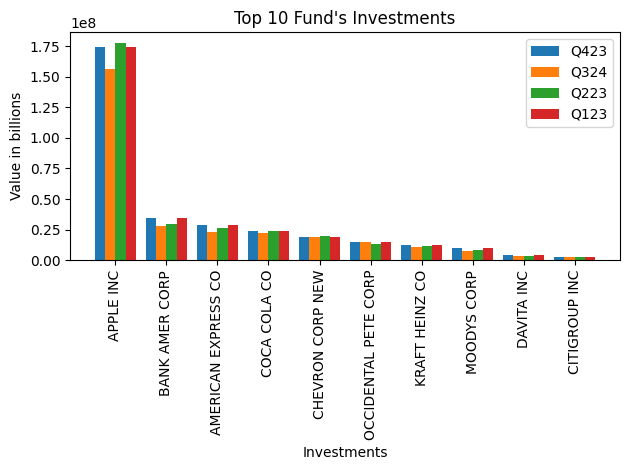

In [36]:
df = final_df.copy().sort_values(by=['value'], ascending=False)

# Calculate threshold for smaller investments to be gr
df = df.sort_values(by='value_Q423', ascending=False).head(10)

categories = df['nameOfIssuer'].tolist()  # Categories
groups = ['Q423', 'Q324', 'Q223', 'Q123']  # Groups
values = {
    'Q423': df['value_Q423'].tolist(),
    'Q324': df['value_Q324'].tolist(),  
    'Q223': df['value_Q223'].tolist(),  
    'Q123': df['value_Q123'].tolist()  # Values for Group 1
}

# Define the width of the bars
bar_width = 0.2

# Set the positions for the bars
x = np.arange(len(categories))

# Plotting the grouped bars
fig, ax = plt.subplots()
for i, group in enumerate(groups):
    positions = x + (i - (len(groups) - 1) / 2) * bar_width
    ax.bar(positions, values[group], bar_width, label=group)

# Add labels and title
ax.set_xlabel('Investments')
ax.set_ylabel('Value in billions')
ax.set_title('Top 10 Fund\'s Investments')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
# Show plot
plt.tight_layout()
plt.show()


### Show only the differences

In [29]:
# sort the df, so we can get the changes of major investments sorted by significance 
df = final_df.copy().sort_values(by=['value_Q423'], ascending=False)

# Specify the columns you want to check for differences
columns_to_check = ['sharesAmount_Q423', 'sharesAmount_Q324', 'sharesAmount_Q223', 'sharesAmount_Q123']

# Filter rows with differences between specific columns
filtered_df = df[df[columns_to_check].apply(lambda x: x.nunique(), axis=1) > 1]
filtered_df[['nameOfIssuer'] + columns_to_check]


,nameOfIssuer,sharesAmount_Q423,sharesAmount_Q324,sharesAmount_Q223,sharesAmount_Q123
5,APPLE INC,"905,560.00","915,560.38","915,560.38","905,560.00"
12,CHEVRON CORP NEW,"126,093.33","110,248.29","123,120.12","126,093.33"
45,OCCIDENTAL PETE CORP,"243,715.80","224,129.19","224,129.19","243,715.80"
2,AMAZON COM INC,"10,000.00","10,000.00","10,551.00","10,000.00"
4,AON PLC,"4,100.00","4,100.00","4,335.00","4,100.00"
46,PARAMOUNT GLOBAL,"63,322.49","93,730.97","93,730.97","63,322.49"
21,HP INC,"22,852.72","102,519.04","120,952.82","22,852.72"
49,SIRIUS XM HOLDINGS INC,"40,243.06","9,683.22",NaN,"40,243.06"
20,GLOBE LIFE INC,NaN,831.01,"2,515.57",NaN
37,MARKEL CORP,NaN,158.71,471.66,NaN


In [30]:
filtered_df[['nameOfIssuer', 'inv_perc_Q423', 'inv_perc_Q324', 'inv_perc_Q223', 'inv_perc_Q123']]

,nameOfIssuer,inv_perc_Q423,inv_perc_Q324,inv_perc_Q223,inv_perc_Q123
5,APPLE INC,50.19,50.04,51.00,38.90
12,CHEVRON CORP NEW,5.41,5.93,5.56,9.78
45,OCCIDENTAL PETE CORP,4.19,4.64,3.78,4.09
2,AMAZON COM INC,0.44,0.41,0.40,0.30
4,AON PLC,0.34,0.42,0.43,0.44
46,PARAMOUNT GLOBAL,0.27,0.39,0.43,0.53
21,HP INC,0.20,0.84,1.07,0.94
49,SIRIUS XM HOLDINGS INC,0.06,0.01,NaN,NaN
20,GLOBE LIFE INC,NaN,0.03,0.08,0.26
37,MARKEL CORP,NaN,0.07,0.19,0.21
